[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/MLP.ipynb)

# Multilayer Perceptron (MLP)
Our goal here is to implement a two-layer neural network for binary classification, train it using gradient descent and use it to classify the Iris dataset.
Our model is
$$
\hat{y} = \sigma \left ( W \sigma \left ( V x \right ) \right)
$$
where we have $M$ hidden units and $D$ input features -- that is $w \in \mathbb{R}^{M}$, and $V \in \mathbb{R}^{M \times D}$. For simplicity here we do not include a bias parameter for each layer. Key to our implementation is the gradient calculation. We follow the notation used in the slides here.

In [1]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

from IPython.core.debugger import set_trace
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold

# Data Preprocessing

In [2]:
# packaging it all into a function
def preprocess_fashion_mnist():
  import random as rand
   
   
  (x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
  # print("\nx_train shape:", x_train.shape, " -- y_train shape", y_train.shape)
  # print("x_test shape", x_test.shape, " -- y_test shape", y_test.shape)
  mean_mat = np.mean(x_train, axis=0)
  # centering the data by removing the pixel wise mean from every pixel in every image
  x_train_centered = x_train - mean_mat
  x_test_centered = x_test - mean_mat
  # normalizing the grayscale values to values in interval [0,1]
  x_train_normalized = x_train_centered/255.0
  x_test_normalized = x_test_centered/255.0

  #finally, flattening the data
  x_train = np.reshape(x_train_normalized, (60000,784))
  x_test = np.reshape(x_test_normalized, (10000, 784))
  #converting the test data to one hot encodings
  y_train = keras.utils.to_categorical(y_train, num_classes=10)
  y_test = keras.utils.to_categorical(y_test, num_classes=10)
  
  return x_train[:10000], y_train[:10000], x_test, y_test
x_train, y_train, x_test, y_test = preprocess_fashion_mnist()

4431872/4422102 [==============================] - 0s 0us/step


# Model Implementation - SoftMax


**Activation functions**

In [3]:
#activation functions
softmax1D = lambda z: np.exp(z)/float(sum(np.exp(z)))
softmax2D = lambda z: np.array([np.exp(i)/float(sum(np.exp(i))) for i in z])

# Logistic
logistic = lambda z: 1./ (1 + np.exp(-z))

# Tanh
tanh = lambda x: 2./ (1+np.exp(-2*x)) -1
tanh_grad = lambda x: 1 - np.square(2./ (1+np.exp(-2*x)) -1)

# Leaky ReLu
def leaky_relu(x):
  alpha = 0.1
  x=np.array(x).astype(float)
  np.putmask(x, x<0, alpha*x)
  return x

def leaky_relu_grad(x):
  alpha = 0.1
  x=np.array(x).astype(float)
  x[x>0]=1
  x[x<=0]=alpha
  return x

  
# ReLu
def relu(x):
  x=np.array(x).astype(float)
  np.putmask(x, x<0, 0)
  return x
  
def relu_grad(x):
  x=np.array(x).astype(float)
  x[x>0]=1
  x[x<=0]=0
  return x

Dimension Indications

Accuracy function

In [4]:
def evaluate_acc(pred, truth):
  counter =0
  
  for i in range(len(pred)):
    maxVal = np.where(pred[i] == np.amax(pred[i]))
    counter += 1 if maxVal == np.where(truth[i]==1) else 0
  return counter * 100.0 / float(len(pred))
  

## Model - ReLu

In [5]:
class MLPReluDropout:
    
    def __init__(self, M = 128, num_classes = 10):
        self.M = M
        self.num_classes = num_classes
        
            
    def fit(self, x, y, optimizer):
        N,D = x.shape
        def gradient(x, y, params):

            p2 = 0.8
            v1, v2, w = params # v1.shape = (D, M), v2.shape = (M, M) w.shape = (M)
            q1 = np.dot(x, v1)
            drop1 = np.random.binomial(1,p2,size=q1.shape[1])/p2 
            q1 *= drop1 
            z1 = relu(q1) #N x M

            q2 = np.dot(z1, v2) # N
            q2 *= np.random.binomial(1,p2,size=q2.shape[1])/p2
            z2 = relu(q2)
            
            yh = softmax2D(np.dot(z2, w))#N
            train_acc = evaluate_acc(yh,y)
            

            ## Backpropagation    
            ## 1st layer
            dy = yh - y #N
            dw = np.dot(z2.T, dy)/N #M  
            
            ## 2nd Layer                  
            # dz = np.dot(dy.T, w)
            dz2 = np.dot(dy, w.numpy().T) #N x M                   = (yh-y)*w from slide 16
            dv2 = np.dot(z1.T, dz2 * relu_grad(q2))/N #D x M   = (yh-y)*w*(activation)'*x
            
            ## 3rd Layer
            dz1 = np.dot(dz2, v2.numpy().T) #N x M                   = (yh-y)*w from slide 16
            dv1 = np.dot(x.T, dz1 * relu_grad(q1))/N #D x M   = (yh-y)*w*(activation)'*x
            
            dparams = [dv1, dv2, dw]
            # print(dparams)
            # print("yh shape:",len(yh[0]))
            return dparams, train_acc
        
        # w = np.random.randn(self.M) * .01
        # v = np.random.randn(D,self.M) * .01
        initializer = keras.initializers.GlorotNormal()
        w = initializer(shape=(self.M, self.num_classes))
        v2 = initializer(shape=(self.M, self.M))
        v1 = initializer(shape=(D, self.M))
        
        params0 = [v1, v2,w]
        self.params, train_accs, batch_train_accs = optimizer.run_mini_batch(gradient, x, y, params0) #optimizer.run(gradient, x, y, params0)#
        return self, train_accs, batch_train_accs
    
    def predict(self, x):
        v1, v2, w = self.params
        z1 = relu(np.dot(x, v1)) #N x M
        z2 = relu(np.dot(z1, v2))
        yh = softmax2D(np.dot(z2, w))#N
        return yh

# Batch Implementation

In the implementation above we have used a list data structure to maintain model parameters and their gradients. Below I have modified the `GradientDescent` class to also work with a list of parameters. One sournce of confusion in the above implementation is the gradient calculation. While in the slides during the lectures 
we calculated the partial derivative for individual parameters, here, we use vector and matrix operations to calculate the derivative for *all* parameters. 

In [6]:
def mini_batcher(x, y, mini_batch_size):
  zipped = np.hstack( (x, y ) )
  np.random.shuffle(zipped)
  x_batches, y_batches = [], []
  mini_batches = []
  batch_num = x.shape[0] // mini_batch_size 
  for i in range(batch_num):
    x_batch = zipped[ i * mini_batch_size : (i+1) * mini_batch_size, :-10]
    y_batch = zipped[ i * mini_batch_size : (i+1) * mini_batch_size, -10:]
    mini_batches.append( ( x_batch, y_batch) )
    # mini_batches.append( ( x_batch, np.argmax(y_batch,axis=1)[:,None] ) )
  if x.shape[0] % mini_batch_size != 0:
    x_batch = zipped[ batch_num * mini_batch_size :, :-10]
    y_batch = zipped[ batch_num * mini_batch_size :, -10:]
    print("Length of last mini-batch =", y_batch.shape[0])
    mini_batches.append( ( x_batch, y_batch ) )
    # mini_batches.append( ( x_batch, np.argmax(y_batch,axis=1) ) )
  # print(mini_batches[0])
  print("yShape = ",y.shape)
  return mini_batches

# Gradient Descent 

---



In [7]:
class GradientDescent:
    
    def __init__(self, learning_rate=.002, max_iters=800, epsilon=1e-8, batch_size=32):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        
    def run(self, gradient_fn, x, y, params):
        norms = np.array([np.inf])
        t = 1
        while np.any(norms > self.epsilon) and t < self.max_iters:
            grad = gradient_fn(x, y, params)
            for p in range(len(params)):
                params[p] -= self.learning_rate * grad[p]
            t += 1
            norms = np.array([np.linalg.norm(g) for g in grad])
        print(t)
        return params
    
    def run_mini_batch(self, gradient_fn, x, y, params, batch_size=32):
        train_acc, batch_train_acc, chunk = [], [], []
        norms = np.array([np.inf])
        t=1
        mini_batches = mini_batcher(x, y, batch_size)
        # print(mini_batches[0])
        while np.any(norms > self.epsilon) and t < self.max_iters * len(mini_batches):
            x_temp, y_temp = mini_batches[t % ( len(mini_batches)-1 ) ][0], mini_batches[t % ( len(mini_batches)-1 ) ][1]
            grad, temp_acc = gradient_fn(x_temp, y_temp, params)
            
            for p in range(len(params)):
                params[p] -= self.learning_rate * grad[p]
            chunk.append(temp_acc)
            if t % 10000 == 0:
              print(f"Epoch{t}:{temp_acc}%")
            # print(f"Epoch{t}:{temp_acc}%")
            train_acc.append( ( t, temp_acc ) )
            t += 1
            if t%len(mini_batches) == 2:
              batch_train_acc.append(np.mean(chunk))
              chunk = []
            norms = np.array([np.linalg.norm(g) for g in grad])
        return params, train_acc, batch_train_acc

# MNIST DataSet

In [ ]:
model = MLPReluDropout(M=128, num_classes=10)
optimizer = GradientDescent(learning_rate=.002, batch_size=32)
y_pred, train_accs, batch_train_accs = model.fit(x_train, y_train, optimizer)


Length of last mini-batch = 16
yShape =  (10000, 10)
Epoch10000:9.375%
Epoch20000:18.75%
Epoch30000:12.5%
Epoch40000:18.75%
Epoch50000:15.625%
Epoch60000:15.625%
Epoch70000:37.5%
Epoch80000:18.75%
Epoch90000:18.75%
Epoch100000:43.75%
Epoch110000:21.875%
Epoch120000:18.75%
Epoch130000:43.75%
Epoch140000:40.625%
Epoch150000:25.0%
Epoch160000:28.125%
Epoch170000:18.75%
Epoch180000:31.25%
Epoch190000:34.375%
Epoch200000:43.75%
Epoch210000:21.875%
Epoch220000:31.25%
Epoch230000:56.25%
Epoch240000:25.0%
Epoch250000:31.25%


In [ ]:
print("Number of full training batch iterations:",len(batch_train_accs))
print("Accuracies per training batch:")
for i in batch_train_accs:
  print(i)

Number of full training batch iterations: 800
Accuracies per training batch:
9.375
11.132188498402556
11.321884984025559
11.811102236421725
11.781150159744408
11.681309904153355
11.940894568690096
12.15055910543131
11.022364217252397
11.511581469648561
11.851038338658148
11.531549520766774
12.17052715654952
11.851038338658148
12.220447284345047
11.741214057507987
11.990814696485623
11.701277955271566
12.539936102236421
12.330271565495208
12.070686900958467
12.220447284345047
12.160543130990416
12.579872204472844
12.330271565495208
12.070686900958467
11.501597444089457
12.130591054313099
12.579872204472844
12.28035143769968
12.629792332268371
12.859424920127795
12.819488817891374
12.420127795527156
13.168929712460065
13.827875399361023
12.490015974440894
12.140575079872205
12.919329073482428
12.549920127795527
13.079073482428115
12.799520766773163
13.168929712460065
13.32867412140575
13.208865814696486
13.348642172523961
12.809504792332268
13.488418530351439
13.298722044728434
13.258785

In [ ]:
fig, ax = plt.subplots()
ax.scatter(batch_train_accs, range(len(batch_train_accs)), c='r', marker='x')
ax.legend()
ax.grid(True)
plt.xlabel('accuracy')
plt.ylabel('epoch')
plt.show()

y_test_pred = model.predict(x_test)

NameError: ignored

No handles with labels found to put in legend.


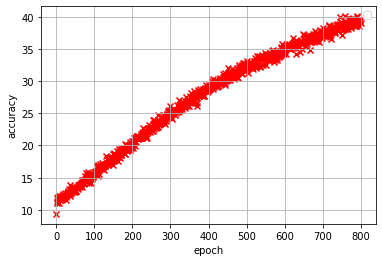

57.16


In [ ]:
fig, ax = plt.subplots()
ax.scatter(range(len(batch_train_accs)), batch_train_accs, c='r', marker='x')
ax.legend()
ax.grid(True)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
print(evaluate_acc(y_test_pred, y_test))

In [10]:
# 128 units, p=0.8 experiment
model = MLPReluDropout(M=128, num_classes=10)
optimizer = GradientDescent(learning_rate=.002, batch_size=32)
y_pred1, train_accs1, batch_train_accs1 = model.fit(x_train, y_train, optimizer)


2022-04-03 20:35:53.240359: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-03 20:35:53.254224: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-03 20:35:53.254706: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-03 20:35:53.258084: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Length of last mini-batch = 16
yShape =  (10000, 10)
Epoch10000:6.25%
Epoch20000:15.625%
Epoch30000:21.875%
Epoch40000:40.625%
Epoch50000:37.5%
Epoch60000:34.375%
Epoch70000:37.5%
Epoch80000:15.625%
Epoch90000:31.25%
Epoch100000:34.375%
Epoch110000:53.125%
Epoch120000:56.25%
Epoch130000:43.75%
Epoch140000:71.875%
Epoch150000:34.375%
Epoch160000:50.0%
Epoch170000:37.5%
Epoch180000:59.375%
Epoch190000:46.875%
Epoch200000:62.5%
Epoch210000:53.125%
Epoch220000:62.5%
Epoch230000:37.5%
Epoch240000:56.25%
Epoch250000:59.375%


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


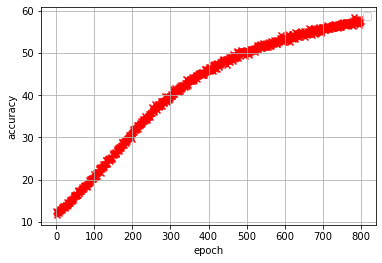

final accuracy: 62.19


In [13]:
fig, ax = plt.subplots()
ax.scatter(range(len(batch_train_accs1)), batch_train_accs1, c='r', marker='x')
ax.legend()
ax.grid(True)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
print('final accuracy:',evaluate_acc(y_pred1.predict(x_test), y_test))

In [21]:
# 256 units, p=0.8 experiment
model = MLPReluDropout(M=256, num_classes=10)
optimizer = GradientDescent(learning_rate=.002, batch_size=32)
y_pred1, train_accs1, batch_train_accs1 = model.fit(x_train, y_train, optimizer)

Length of last mini-batch = 16
yShape =  (10000, 10)
Epoch10000:9.375%
Epoch20000:21.875%
Epoch30000:12.5%
Epoch40000:40.625%
Epoch50000:43.75%
Epoch60000:37.5%
Epoch70000:53.125%
Epoch80000:43.75%
Epoch90000:46.875%
Epoch100000:43.75%
Epoch110000:62.5%
Epoch120000:50.0%
Epoch130000:65.625%
Epoch140000:59.375%
Epoch150000:65.625%
Epoch160000:62.5%
Epoch170000:68.75%
Epoch180000:56.25%
Epoch190000:50.0%
Epoch200000:59.375%
Epoch210000:59.375%
Epoch220000:62.5%
Epoch230000:56.25%
Epoch240000:62.5%
Epoch250000:68.75%


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


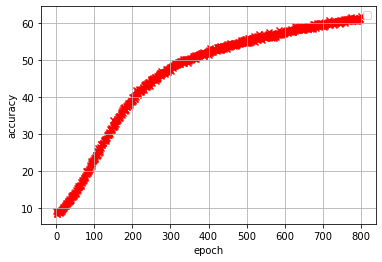

final accuracy: 65.07


In [22]:
fig, ax = plt.subplots()
ax.scatter(range(len(batch_train_accs1)), batch_train_accs1, c='r', marker='x')
ax.legend()
ax.grid(True)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
print('final accuracy:',evaluate_acc(y_pred1.predict(x_test), y_test))

In [31]:
# new experiment
model = MLPReluDropout(M=256, num_classes=10)
optimizer = GradientDescent(learning_rate=.002, batch_size=32)
y_pred1, train_accs1, batch_train_accs1 = model.fit(x_train, y_train, optimizer)

Length of last mini-batch = 16
yShape =  (10000, 10)
Epoch10000:18.75%
Epoch20000:15.625%
Epoch30000:6.25%
Epoch40000:3.125%
Epoch50000:21.875%
Epoch60000:21.875%
Epoch70000:18.75%
Epoch80000:18.75%
Epoch90000:18.75%
Epoch100000:18.75%
Epoch110000:21.875%
Epoch120000:37.5%
Epoch130000:31.25%
Epoch140000:34.375%
Epoch150000:25.0%
Epoch160000:40.625%
Epoch170000:43.75%
Epoch180000:50.0%
Epoch190000:18.75%
Epoch200000:31.25%
Epoch210000:46.875%
Epoch220000:46.875%
Epoch230000:28.125%
Epoch240000:53.125%
Epoch250000:40.625%


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


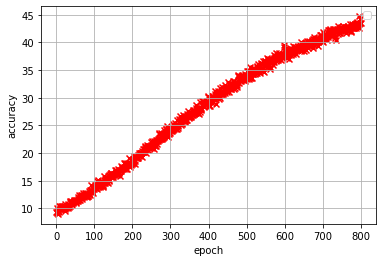

final accuracy: 57.14


In [32]:
fig, ax = plt.subplots()
ax.scatter(range(len(batch_train_accs1)), batch_train_accs1, c='r', marker='x')
ax.legend()
ax.grid(True)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
print('final accuracy:',evaluate_acc(y_pred1.predict(x_test), y_test))

Length of last mini-batch = 16
yShape =  (10000, 10)
Epoch10000:25.0%
Epoch20000:15.625%
Epoch30000:28.125%
Epoch40000:9.375%
Epoch50000:25.0%
Epoch60000:21.875%
Epoch70000:43.75%
Epoch80000:37.5%
Epoch90000:43.75%
Epoch100000:34.375%
Epoch110000:37.5%
Epoch120000:46.875%
Epoch130000:62.5%
Epoch140000:40.625%
Epoch150000:65.625%
Epoch160000:46.875%
Epoch170000:46.875%
Epoch180000:59.375%
Epoch190000:59.375%
Epoch200000:56.25%
Epoch210000:53.125%
Epoch220000:43.75%
Epoch230000:62.5%
Epoch240000:43.75%
Epoch250000:62.5%
Epoch260000:56.25%
Epoch270000:50.0%
Epoch280000:50.0%
Epoch290000:53.125%
Epoch300000:75.0%
Epoch310000:56.25%
Epoch320000:50.0%
Epoch330000:71.875%
Epoch340000:56.25%
Epoch350000:53.125%
Epoch360000:75.0%
Epoch370000:53.125%
Epoch380000:62.5%
Epoch390000:43.75%
Epoch400000:62.5%
Epoch410000:84.375%
Epoch420000:71.875%
Epoch430000:59.375%
Epoch440000:71.875%
Epoch450000:46.875%
Epoch460000:75.0%
Epoch470000:59.375%
Epoch480000:59.375%
Epoch490000:75.0%
Epoch500000:68.75%

No handles with labels found to put in legend.


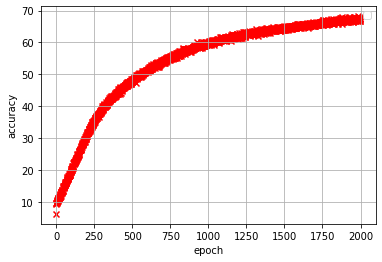

final accuracy: 70.84


In [9]:
# final experiments: 2000 max iterations
# M=128, p=0.8
model1 = MLPReluDropout(M=128, num_classes=10)
optimizer = GradientDescent(learning_rate=.002, batch_size=32, max_iters=2000)
y_pred1, train_accs1, batch_train_accs1 = model1.fit(x_train, y_train, optimizer)
fig, ax = plt.subplots()
ax.scatter(range(len(batch_train_accs1)), batch_train_accs1, c='r', marker='x')
ax.legend()
ax.grid(True)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
print('final accuracy:',evaluate_acc(y_pred1.predict(x_test), y_test))

Length of last mini-batch = 16
yShape =  (10000, 10)
Epoch10000:6.25%
Epoch20000:25.0%
Epoch30000:18.75%
Epoch40000:28.125%
Epoch50000:28.125%
Epoch60000:43.75%
Epoch70000:59.375%
Epoch80000:56.25%
Epoch90000:59.375%
Epoch100000:37.5%
Epoch110000:50.0%
Epoch120000:46.875%
Epoch130000:50.0%
Epoch140000:59.375%
Epoch150000:62.5%
Epoch160000:46.875%
Epoch170000:62.5%
Epoch180000:59.375%
Epoch190000:56.25%
Epoch200000:62.5%
Epoch210000:46.875%
Epoch220000:53.125%
Epoch230000:59.375%
Epoch240000:46.875%
Epoch250000:65.625%
Epoch260000:40.625%
Epoch270000:62.5%
Epoch280000:56.25%
Epoch290000:68.75%
Epoch300000:68.75%
Epoch310000:71.875%
Epoch320000:71.875%
Epoch330000:62.5%
Epoch340000:53.125%
Epoch350000:68.75%
Epoch360000:68.75%
Epoch370000:59.375%
Epoch380000:71.875%
Epoch390000:62.5%
Epoch400000:62.5%
Epoch410000:75.0%
Epoch420000:62.5%
Epoch430000:68.75%
Epoch440000:59.375%
Epoch450000:62.5%
Epoch460000:71.875%
Epoch470000:75.0%
Epoch480000:75.0%
Epoch490000:65.625%
Epoch500000:65.625%


No handles with labels found to put in legend.


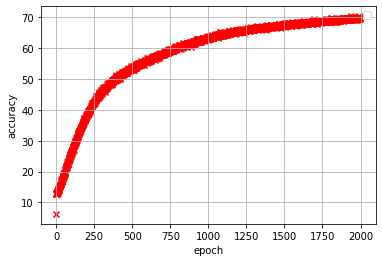

final accuracy: 71.11


In [10]:
# final experiments: 2000 max iterations
# M=256, p=0.8
model2 = MLPReluDropout(M=256, num_classes=10)
optimizer = GradientDescent(learning_rate=.002, batch_size=32, max_iters=2000)
y_pred2, train_accs2, batch_train_accs2 = model2.fit(x_train, y_train, optimizer)
fig, ax = plt.subplots()
ax.scatter(range(len(batch_train_accs2)), batch_train_accs2, c='r', marker='x')
ax.legend()
ax.grid(True)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
print('final accuracy:',evaluate_acc(y_pred2.predict(x_test), y_test))